# Visão Computacional e Deep Learning para Sensoriamento Remoto com Python


# Capítulo 12 - Arquiteturas Avançadas de Segmentação Semântica - Parte 1

## Como criar patches de máscara e imagens de Ortomosaics a partir de shapefiles

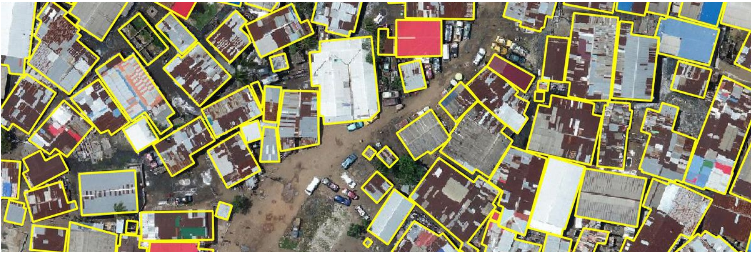

Demonstraremos como convertemos alvo de shapefiles em máscaras para treinar modelos de segmentação semântica. O conjunto de dados usado neste exemplo faz parte do desafio Open Cities AI que vamos utilizar depois:

In [ ]:
!pip install rasterio
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 44.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import os
import cv2
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from rasterio.merge import merge
from rasterio.plot import show

In [ ]:
path = '/content/drive/MyDrive/Datasets/OpenCitiesAI/mon/493701/493701.tif'

Vamos abrir o arquivo, ler os dados brutos como arrays numpy e realizar a transposição do eixo da banda:

In [ ]:
src = rasterio.open(path)

In [ ]:
img = src.read()

In [ ]:
img.shape

(4, 21783, 22333)

In [ ]:
img = img.transpose([1,2,0])

Após abrir a imagem armazenada no Drive, vamos verificar o CRS:

In [ ]:
src.crs

CRS.from_epsg(32629)

Usando o matplotlib, vamos ver a imagem:

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(img)
plt.axis('off')

Agora vamos trabalhar com os rótulos. Primeiro importamos usando Geopandas e depois definimos o mesmo CRS da Imagem:

In [ ]:
path_labels = '/content/drive/MyDrive/Datasets/OpenCitiesAI/mon/493701-labels/493701.geojson'

In [ ]:
label = gpd.read_file(path_labels)

In [ ]:
label = label.to_crs(32629)

Também iremos plotar:

<Axes: >

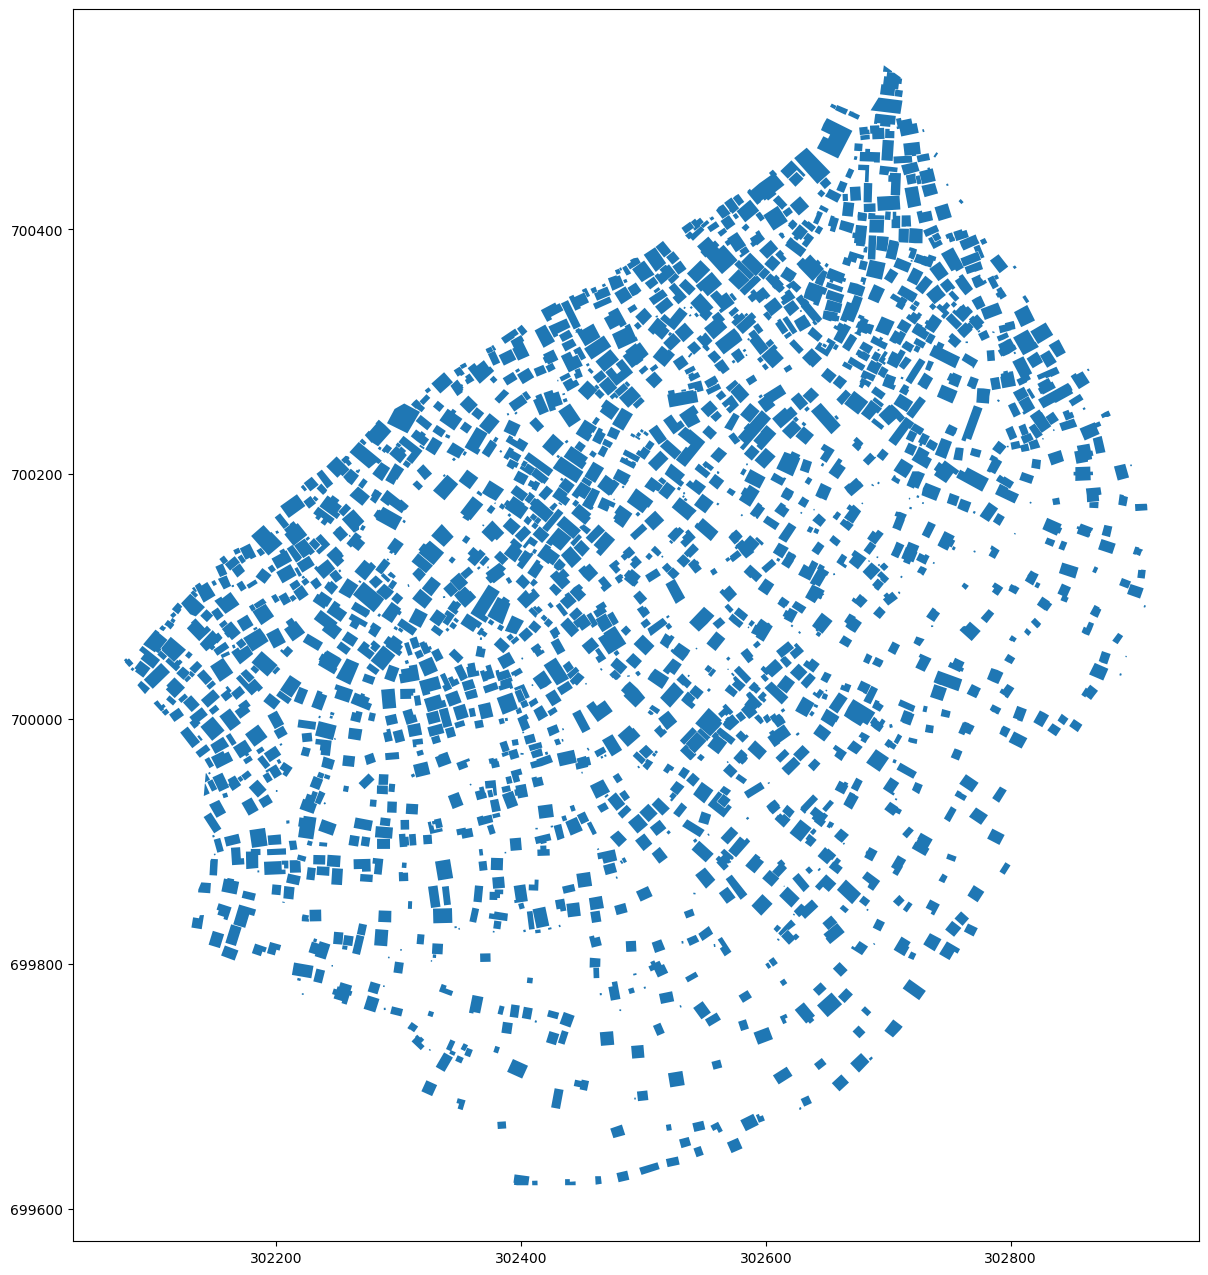

In [ ]:
label.plot(figsize=(16,16))

Vamos usar a função rasterize para converter os vetores alvo em uma imagem com 0 e 1. O número 1 representa os polígonos e o 0 representa o fundo.

In [ ]:
from rasterio.features import rasterize

In [ ]:
shape_target = src.shape
out_arr = np.zeros(shape_target)
out_target = src.meta.copy()
mask_rasterized = rasterize( [(x.geometry, 1) for i, x in label.iterrows()],
                                transform=src.transform,
                                fill=0,
                                out = out_arr,
                                dtype=rasterio.uint8)
del out_arr
out_target.update({"driver": "GTiff",
                              "nodata":0,
                               "dtype":rasterio.uint8,
                               "compress":'lzw',
                               "count":1})
path_exp_target = '/content/mask_target.tif'
with rasterio.open(path_exp_target, 'w', **out_target) as msk:
    msk.write(mask_rasterized, indexes=1)

O arquivo resultante foi salvo no /content com o nome mask_target.tiff

Então, vamos abri-lo e plotá-lo:

In [ ]:
tgt = rasterio.open(path_exp_target)

In [ ]:
tgt_arr = tgt.read(1)

(-0.5, 22332.5, 21782.5, -0.5)

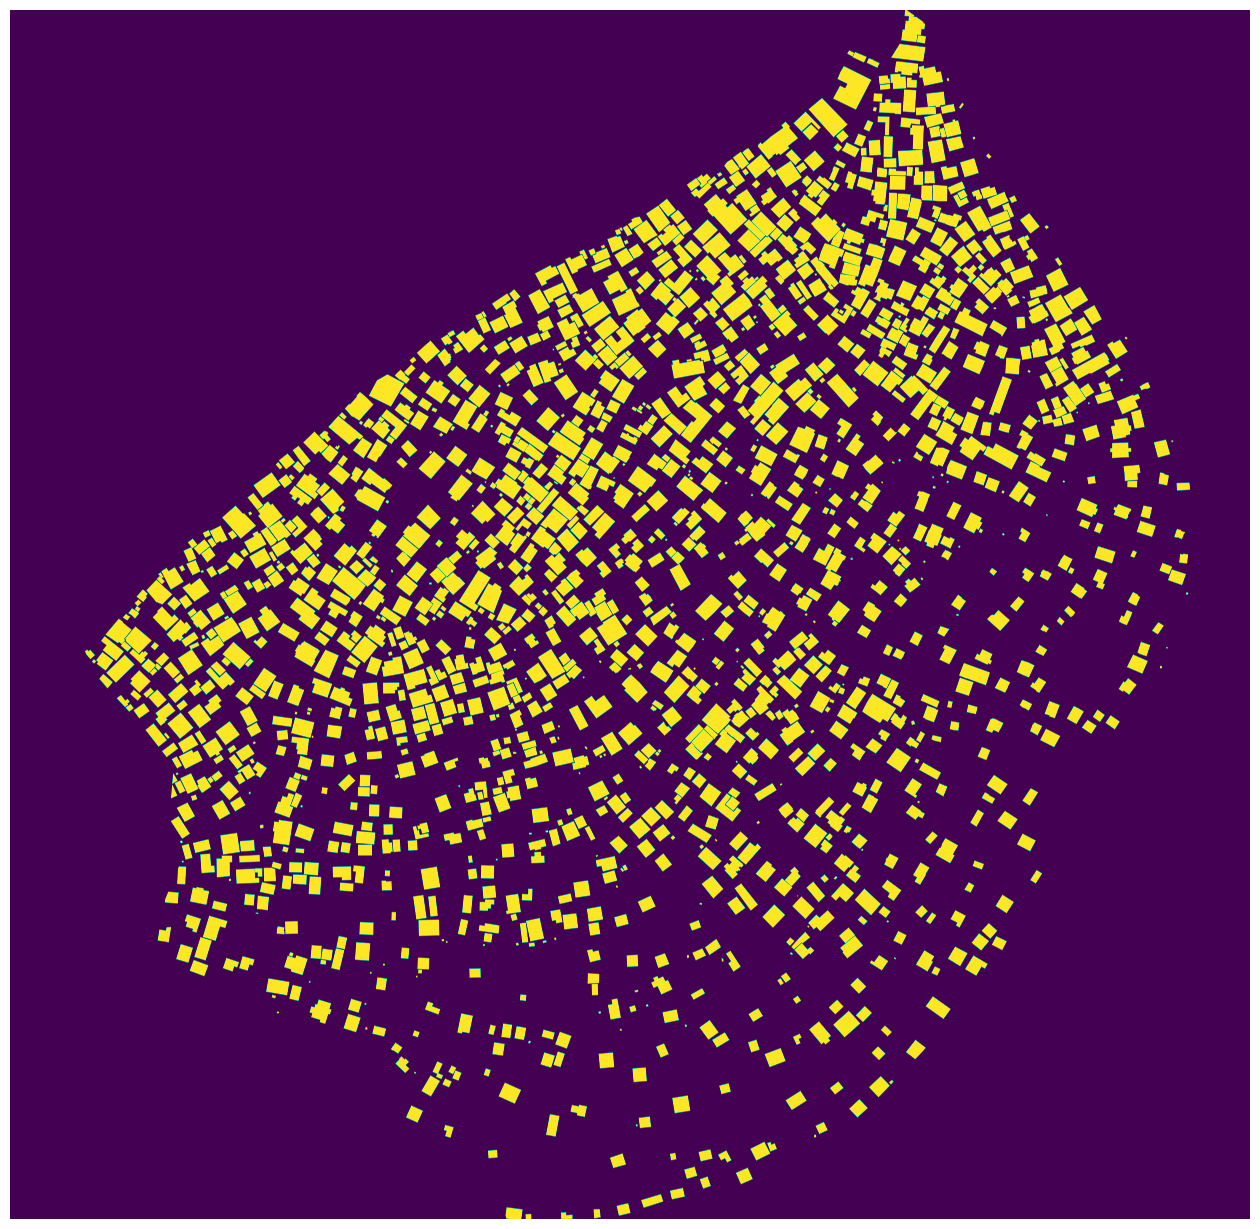

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(tgt_arr)
plt.axis('off')

Criaremos uma pasta no conteúdo para armazenar os patches de imagens e máscaras:

In [ ]:
from os import mkdir

In [ ]:
mkdir('data')

E por fim vamos passar pela imagem e pela máscara, dividindo-as em patches de 512x512 pixels.

In [ ]:
from rasterio.windows import Window

In [ ]:
qtd = 0
out_meta = src.meta.copy()
out_meta_tgt = tgt.meta.copy()
for n in range((src.meta['width']//512)):
  for m in range((src.meta['height']//512)):
    x = (n*512)
    y = (m*512)
    window = Window(x,y,512,512)
    win_transform = src.window_transform(window)
    arr_win = src.read(window=window)
    arr_win = arr_win[0:3]
    tgt_transform = tgt.window_transform(window)
    tgt_win = tgt.read(window=window)
    if (arr_win.max() != 0):
      qtd = qtd + 1
      path_exp = '/content/data/img_' + str(qtd) + '.tif'
      out_meta.update({"driver": "GTiff","height": 512,"width": 512, "count":len(arr_win), "compress":'lzw', "transform":win_transform})
      with rasterio.open(path_exp, 'w', **out_meta) as dst:
          for i, layer in enumerate(arr_win, start=1):
              dst.write_band(i, layer.reshape(-1, layer.shape[-1]))
      path_exp_mask = '/content/data/msk_' + str(qtd) + '.tif'
      out_meta_tgt.update({"driver": "GTiff","height": 512,"width": 512, "compress":'lzw', "transform":tgt_transform})
      with rasterio.open(path_exp_mask, 'w', **out_meta_tgt) as msk:
          msk.write(tgt_win.reshape(-1, tgt_win.shape[-1]), indexes=1)
      print('Create img and mask: ' + str(qtd))
    del tgt_win
    del arr_win

Create img and mask: 1
Create img and mask: 2
Create img and mask: 3
Create img and mask: 4
Create img and mask: 5
Create img and mask: 6
Create img and mask: 7
Create img and mask: 8
Create img and mask: 9
Create img and mask: 10
Create img and mask: 11
Create img and mask: 12
Create img and mask: 13
Create img and mask: 14
Create img and mask: 15
Create img and mask: 16
Create img and mask: 17
Create img and mask: 18
Create img and mask: 19
Create img and mask: 20
Create img and mask: 21
Create img and mask: 22
Create img and mask: 23
Create img and mask: 24
Create img and mask: 25
Create img and mask: 26
Create img and mask: 27
Create img and mask: 28
Create img and mask: 29
Create img and mask: 30
Create img and mask: 31
Create img and mask: 32
Create img and mask: 33
Create img and mask: 34
Create img and mask: 35
Create img and mask: 36
Create img and mask: 37
Create img and mask: 38
Create img and mask: 39
Create img and mask: 40
Create img and mask: 41
Create img and mask: 42
C

Finalmente podemos importar os patches criados e plotar com matplotlib:

In [ ]:
X = []
images_files = [f for f in os.listdir('/content/data/') if f.startswith('img')]
images_files.sort()
for files in images_files:
  import_raster = os.path.join('/content/data/',files)
  with rasterio.open(import_raster) as src:
    im = src.read()
    im = im.transpose([1,2,0])
    im = cv2.resize(im, (256,256))
  X.append(im)
X = np.array(X)
print(X.shape)

(1198, 256, 256, 3)


In [ ]:
Y = []
images_files = [f for f in os.listdir('/content/data/') if f.startswith('msk')]
images_files.sort()
for files in images_files:
  import_raster = os.path.join('/content/data/',files)
  with rasterio.open(import_raster) as src:
    im = src.read()
    im = im.transpose([1,2,0])
    im = cv2.resize(im, (256,256))
  Y.append(im)
Y = np.array(Y)
print(Y.shape)

(1198, 256, 256)


(-0.5, 255.5, 255.5, -0.5)

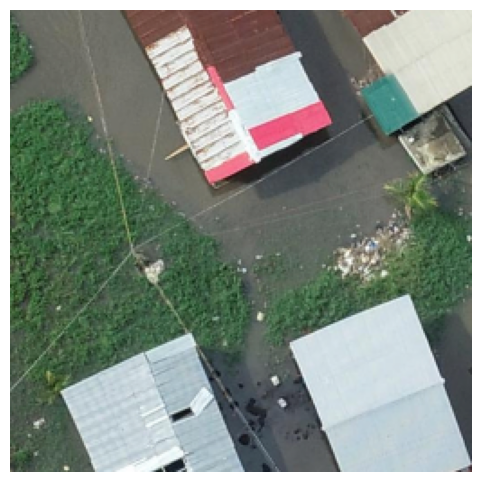

In [ ]:
plt.figure(figsize=[6,6])
plt.imshow(X[80,:,:,0:3])
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

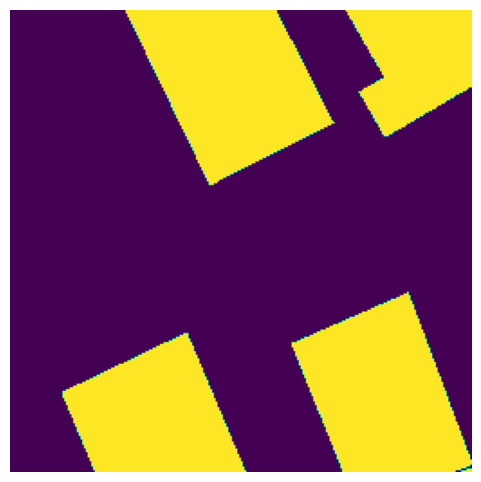

In [ ]:
plt.figure(figsize=[6,6])
plt.imshow(np.round(Y[80,:,:]))
plt.axis('off')

## Segmentação de Áreas Construídas com o  Open Cities AI Challenge Dataset

"Neste desafio, você estará segmentando casas e edifícios a partir de imagens aéreas. Os dados consistem em imagens de drones de 10 cidades e regiões diferentes em toda a África. Seu objetivo é classificar a presença ou ausência de um edifício pixel a pixel ."

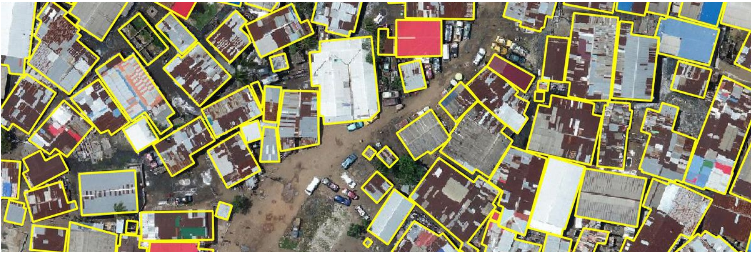

Neste exemplo, usaremos os dados preparados anteriormente para criar um modelo de segmentação de casas e construções.

Vamos plotar novamente um exemplo de uma imagem e sua respectiva máscara:

(-0.5, 255.5, 255.5, -0.5)

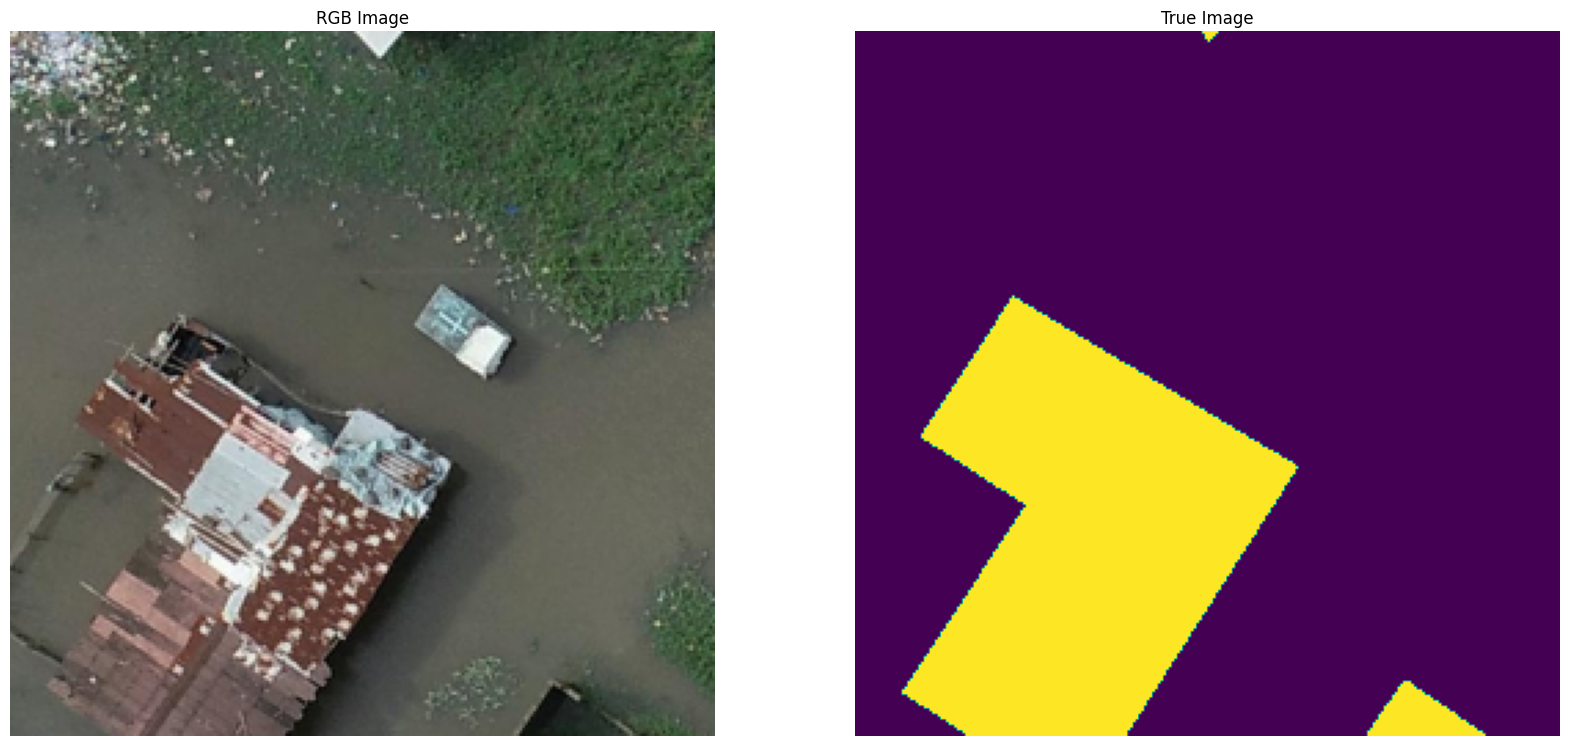

In [ ]:
i = 1000
plt.figure(figsize=[20,20])
plt.subplot(121)
plt.imshow(X[i,:,:,:])
plt.title('RGB Image')
plt.axis('off')
plt.subplot(122)
plt.imshow(Y[i,:,:])
plt.title('True Image')
plt.axis('off')

Agora vamos preparar os dados para alimentar a rede neural, dividindo-a em dados de treinamento e teste, redimensionando os valores e também importando algumas funções do Keras:

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [ ]:
x_train = x_train/255
x_test = x_test/255

In [ ]:
y_train = y_train.astype('float')
y_test = y_test.astype('float')

In [ ]:
from keras.models import Model
from keras.regularizers import l2
from keras.layers import *
from keras.models import *
import keras.backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:
def jaccard_coef(y_true, y_pred,smooth=100):
  # __author__ = Vladimir Iglovikov
  intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
  sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

  jac = (intersection + smooth) / (sum_ - intersection + smooth)

  return K.mean(jac)

def jaccard_loss(y_true, y_pred):
  return 1 - jaccard_coef(y_true, y_pred)

def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


Vamos aplicar o aumento de dados para gerar mais amostrar.

In [ ]:
img_datagen = ImageDataGenerator(
    rotation_range=90,
    vertical_flip = True,
    horizontal_flip=True)

mask_datagen = ImageDataGenerator(
    rotation_range=90,
    vertical_flip = True,
    horizontal_flip=True)

In [ ]:
img_datagen.fit(x_train, augment=True,seed=1200)
mask_datagen.fit(y_train[:,:,:,np.newaxis], augment=True,seed=1200)

In [ ]:
X=img_datagen.flow(x_train,batch_size=8,seed=1200)
Y=mask_datagen.flow(y_train[:,:,:,np.newaxis],batch_size=8,seed=1200)

In [ ]:
train_generator = zip(X, Y)

In [ ]:
steps_per_epoch = len(x_train)//8
validation_steps = len(x_test)//8

##ResUnet

RESUNET é uma rede neural totalmente convolucional projetada para obter alto desempenho com menos parâmetros. É uma melhoria em relação à arquitetura UNET existente. O RESUNET aproveita a arquitetura UNET e o Deep Residual Learning.

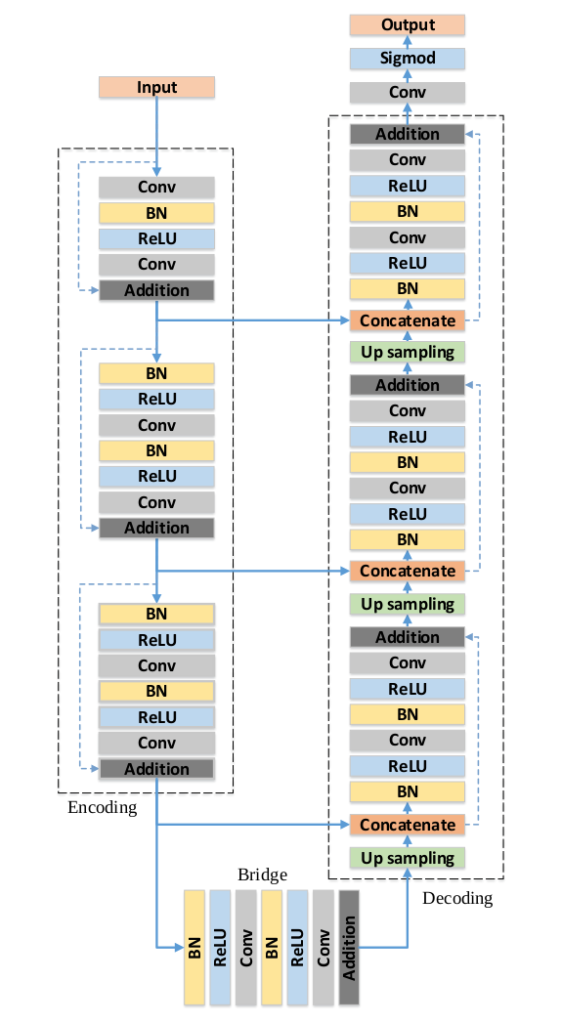

### Vantagens RESUNET:



O uso de blocos residuais ajuda na construção de uma rede mais profunda sem se preocupar com o problema de desaparecimento de gradiente ou explosão de gradientes. Também ajuda no treinamento fácil da rede.
As ricas conexões de salto no RESUNET ajudam no melhor fluxo de informações entre diferentes camadas, o que ajuda no melhor fluxo de gradientes durante o treinamento (backpropagation).

### Arquitetura geral

A RESUNET consiste em uma rede de codificação, rede de decodificação e uma ponte conectando ambas as redes, como uma U-Net. A U-Net usa duas convoluções 3 x 3, onde cada uma é seguida por uma função de ativação ReLU. No caso do RESUNET, essas camadas são substituídas por um bloco residual pré-ativado.

- Codificador:

O codificador pega a imagem de entrada e a passa por diferentes blocos codificadores, o que ajuda a rede a aprender uma representação abstrata. O encoder consiste em três blocos de encoder, que são construídos usando o bloco residual pré-ativado. A saída de cada bloco do codificador atua como uma conexão de salto para o bloco decodificador correspondente.

Para reduzir as dimensões espaciais (altura e largura) dos mapas de recursos, a primeira camada de convolução 3 × 3 usa um passo de 2 no segundo e no terceiro bloco codificador. Um valor de passo de 2 reduz as dimensões espaciais pela metade, ou seja, 256 a 128.

- Ponte:

A ponte também consiste em um bloco residual pré-ativado com um valor de passo de 2.

- Decodificador:

O decodificador pega o mapa de recursos da ponte e as conexões de salto de diferentes blocos codificadores e aprende uma melhor representação semântica, que é usada para gerar uma máscara de segmentação.

O decodificador consiste em três blocos decodificadores e, após cada bloco, as dimensões espaciais do mapa de recursos são duplicadas e o número de canais de recursos é reduzido.

Vamos implementar ResUnet usando keras:

In [ ]:
def conv_block(input_tensor, filters, strides, d_rates):
    x = Conv2D(filters[0], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[0])(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[1], kernel_size=3, strides=strides, kernel_initializer='he_uniform', padding='same', dilation_rate=d_rates[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[2], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[2])(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters[2], kernel_size=1, kernel_initializer='he_uniform', strides=strides)(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)

    return x


def identity_block(input_tensor, filters, d_rates):
    x = Conv2D(filters[0], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[0])(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[1], kernel_size=3, kernel_initializer='he_uniform', padding='same', dilation_rate=d_rates[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters[2], kernel_size=1, kernel_initializer='he_uniform', dilation_rate=d_rates[2])(x)
    x = BatchNormalization()(x)

    x = add([x, input_tensor])
    x = Activation('relu')(x)

    return x

def one_side_pad(x):
    x = ZeroPadding2D((1, 1))(x)
    x = Lambda(lambda x: x[:, :-1, :-1, :])(x)
    return x

In [ ]:
droprate = 0.2
inputs = Input(shape=x_train.shape[1:])
conv_1 = Conv2D(32, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='same')(inputs)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Activation("relu")(conv_1)
f1 = conv_1

conv_2 = Conv2D(64, (3, 3), strides=(2, 2), kernel_initializer='he_uniform', padding='same')(conv_1)
conv_2 = BatchNormalization()(conv_2)
conv_2 = Activation("relu")(conv_2)

conv_3 = Conv2D(64, (3, 3), strides=(1, 1), kernel_initializer='he_uniform', padding='same')(conv_2)
conv_3 = BatchNormalization()(conv_3)
conv_3 = Activation("relu")(conv_3)

f2 = conv_3


pool_1 = MaxPooling2D((2, 2), strides=(2, 2))(conv_3)

conv_block1 = conv_block(pool_1, filters=[64, 64, 128], strides=(1, 1), d_rates=[1, 1, 1])
identity_block1 = identity_block(conv_block1, filters=[64, 64, 128], d_rates=[1, 2, 1])
identity_block2 = identity_block(identity_block1, filters=[64, 64, 128], d_rates=[1, 3, 1])
f3 = identity_block2

conv_block2 = conv_block(identity_block2, filters=[128, 128, 256], strides=(2, 2), d_rates=[1, 1, 1])
identity_block3 = identity_block(conv_block2, filters=[128, 128, 256], d_rates=[1, 2, 1])
identity_block4 = identity_block(identity_block3, filters=[128, 128, 256], d_rates=[1, 3, 1])
identity_block5 = identity_block(identity_block4, filters=[128, 128, 256], d_rates=[1, 4, 1])
f4 = identity_block5


identity_block10 = conv_block(identity_block5, filters=[256, 256, 512], strides=(2, 2), d_rates=[1, 1, 1])
for i in range(5):
  identity_block10 = identity_block(identity_block10, filters=[256, 256, 512], d_rates=[1, 2, 1])

f5 = identity_block10

conv_block4 = conv_block(identity_block10, filters=[512, 512, 1024], strides=(2, 2), d_rates=[1, 1, 1])
identity_block11 = identity_block(conv_block4, filters=[512, 512, 1024], d_rates=[1, 4, 1])
identity_block12 = identity_block(identity_block11, filters=[512, 512, 1024], d_rates=[1, 4, 1])
f6 = identity_block12

o = f6

o = (BatchNormalization())(o)
o = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Dropout(droprate)(o)


o = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(o)
o = (concatenate([o, f5]))
o = (BatchNormalization())(o)
o = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Dropout(droprate)(o)



o = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(o)
o = (concatenate([o, f4]))
o = (BatchNormalization())(o)
o = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Dropout(droprate)(o)



o = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(o)
o = (concatenate([o, f3]))
o = (BatchNormalization())(o)
o = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Dropout(droprate)(o)



o = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(o)
o = (concatenate([o, f2]))
o = (BatchNormalization())(o)
o = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Dropout(droprate)(o)


o = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(o)
o = (concatenate([o, f1]))
o = (BatchNormalization())(o)
o = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)
o = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(o)


o = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(o)

model = Model(inputs=inputs, outputs=o)
model.compile(optimizer=Adam(lr = 1e-5,decay=1e-6), loss = dice_coef_loss, metrics = ['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 activation_15 (Activation)     (None, 32, 32, 128)  0           ['batch_normalization_17[0][0]'] 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 32, 32, 128)  147584      ['activation_15[0][0]']          
                                                                                                  
 batch_normalization_18 (BatchN  (None, 32, 32, 128)  512        ['conv2d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_16 (Activation)     (None, 32, 32, 128)  0           ['batch_normalization_18[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 32, 32, 256)  33024       ['activation_16[0][0]']          
          

E então podemos treinar o modelo por 300 épocas:

In [ ]:
history = model.fit_generator(train_generator,steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
                              epochs=300, validation_data=(x_test,y_test))

<ipython-input-53-3caab27a3ebc>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,


Epoch 1/300
104/104 [==============================] - 40s 179ms/step - loss: 0.5674 - accuracy: 0.3436 - val_loss: 0.6001 - val_accuracy: 0.3957
Epoch 2/300
104/104 [==============================] - 18s 153ms/step - loss: 0.5023 - accuracy: 0.6548 - val_loss: 0.5434 - val_accuracy: 0.8271
Epoch 3/300
104/104 [==============================] - 16s 156ms/step - loss: 0.4243 - accuracy: 0.8225 - val_loss: 0.4241 - val_accuracy: 0.8999
Epoch 4/300
104/104 [==============================] - 16s 154ms/step - loss: 0.3489 - accuracy: 0.8631 - val_loss: 0.3038 - val_accuracy: 0.9031
Epoch 5/300
104/104 [==============================] - 16s 155ms/step - loss: 0.2850 - accuracy: 0.8841 - val_loss: 0.2561 - val_accuracy: 0.9027
Epoch 6/300
104/104 [==============================] - 16s 151ms/step - loss: 0.2511 - accuracy: 0.8897 - val_loss: 0.2368 - val_accuracy: 0.9020
Epoch 7/300
104/104 [==============================] - 16s 153ms/step - loss: 0.2437 - accuracy: 0.8916 - val_loss: 0.2220 -

Após o término do treinamento, traçaremos as curvas de precisão e perda:

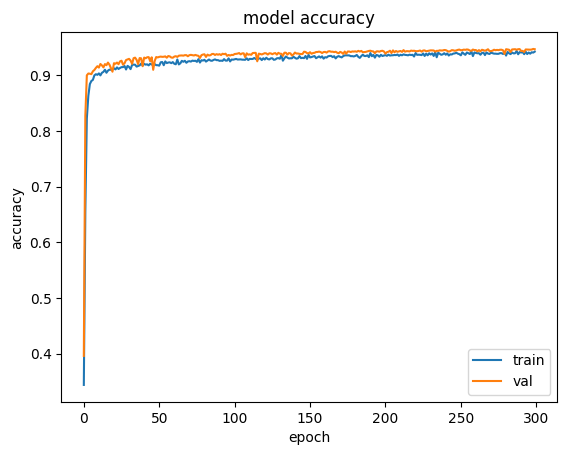

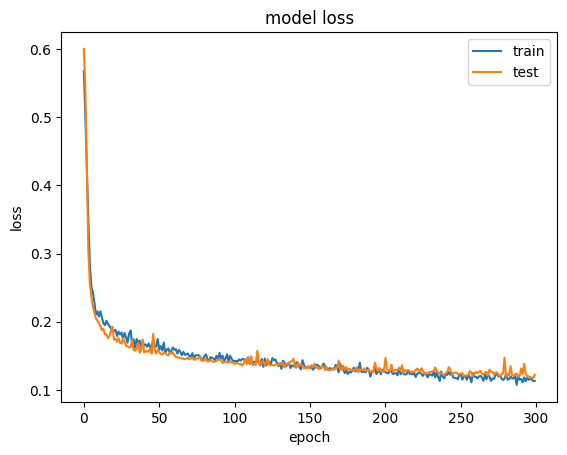

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Assim, podemos calcular a acurácia para o conjunto de teste:

In [ ]:
predict = model.predict(x_test)

12/12 [==============================] - 5s 73ms/step


In [ ]:
pred = np.round(predict)

In [ ]:
accuracy = accuracy_score(y_test.flatten(),pred.flatten())
print(accuracy)

0.9467164357503255


In [ ]:
y_test.shape

(360, 256, 256)

Por fim, vamos plotar um exemplo do resultado previsto em comparação com a máscara original:

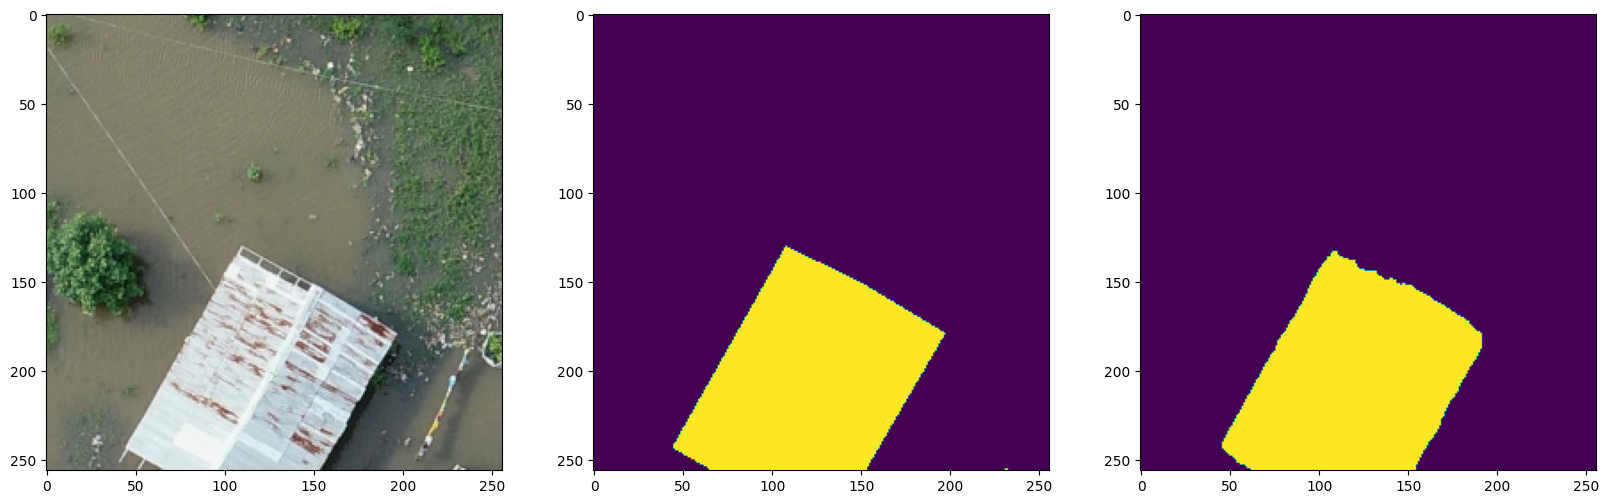

In [ ]:
i = 0
plt.figure(figsize=(20,8))
plt.subplot(1,3,1),
plt.imshow(x_test[i])
plt.subplot(1,3,2),
plt.imshow(y_test[i,:,:])
plt.subplot(1,3,3),
plt.imshow(pred[i,:,:,0])

## Predição do Ortomosaico

Depois de treinar o modelo, vamos aplicar ao ortomosaico inteiro. Primeiro divimos em janelas de 512x512 pixels e salvamos em formato tiff.

In [ ]:
path_img_to_pred = '/content/drive/MyDrive/Datasets/OpenCitiesAI/mon/493701/493701.tif'
path_split = "/content/split_img"
if not os.path.isdir(path_split):
    os.mkdir(path_split)

path_exp = "/content/mask_predict"
if not os.path.isdir(path_exp):
    os.mkdir(path_exp)

In [ ]:
src = rasterio.open(path_img_to_pred)
out_meta = src.meta.copy()
qtd = 0
for n in range((src.meta['width']//512)):
  for m in range((src.meta['height']//512)):
    x = ((n*512))
    y = ((m*512))
    window = Window(x,y,512,512)
    win_transform = src.window_transform(window)
    arr_win = src.read(window=window)
    arr_win = arr_win[0:3]
    if (arr_win.max() != 0) and (arr_win.shape[1] == 512) and (arr_win.shape[2] == 512):
      qtd = qtd + 1
      path_exp_img = os.path.join(path_split, 'img_' + str(qtd) + '.tif')
      out_meta.update({"driver": "GTiff","height": 512,"width": 512, "count":len(arr_win), "compress":'lzw', "transform":win_transform})
      with rasterio.open(path_exp_img, 'w', **out_meta) as dst:
          for i, layer in enumerate(arr_win, start=1):
              dst.write_band(i, layer.reshape(-1, layer.shape[-1]))
      print('Create img: ' + str(qtd))
    del arr_win

Create img: 1
Create img: 2
Create img: 3
Create img: 4
Create img: 5
Create img: 6
Create img: 7
Create img: 8
Create img: 9
Create img: 10
Create img: 11
Create img: 12
Create img: 13
Create img: 14
Create img: 15
Create img: 16
Create img: 17
Create img: 18
Create img: 19
Create img: 20
Create img: 21
Create img: 22
Create img: 23
Create img: 24
Create img: 25
Create img: 26
Create img: 27
Create img: 28
Create img: 29
Create img: 30
Create img: 31
Create img: 32
Create img: 33
Create img: 34
Create img: 35
Create img: 36
Create img: 37
Create img: 38
Create img: 39
Create img: 40
Create img: 41
Create img: 42
Create img: 43
Create img: 44
Create img: 45
Create img: 46
Create img: 47
Create img: 48
Create img: 49
Create img: 50
Create img: 51
Create img: 52
Create img: 53
Create img: 54
Create img: 55
Create img: 56
Create img: 57
Create img: 58
Create img: 59
Create img: 60
Create img: 61
Create img: 62
Create img: 63
Create img: 64
Create img: 65
Create img: 66
Create img: 67
Crea

Agora é só aplicar o modelo em cada uma das imagens:

In [ ]:
n = [f for f in os.listdir(path_split)]

In [ ]:
for path_img in n:
  img = []
  path_full = os.path.join(path_split,path_img)
  ds = rasterio.open(path_full, 'r')
  im = ds.read()
  im = im.transpose([1,2,0])
  im = im/255
  im = im[np.newaxis,:,:,:]
  predict = model.predict(im)
  predict = np.round(predict).astype(np.uint8)
  print(path_img.split('_')[1])
  out_meta = ds.meta.copy()
  w = ds.meta['width']
  h = ds.meta['height']
  path_exp_1 = os.path.join(path_exp,'Pred_' + path_img.split('_')[1])
  out_meta.update({"driver": "GTiff","dtype":rasterio.uint8,"compress":'lzw',"count":1,"nodata":0})
  with rasterio.open(path_exp_1, 'w', **out_meta) as dst:
      dst.write(predict[0,:,:,0], indexes=1)

1/1 [==============================] - 3s 3s/step
649.tif
1/1 [==============================] - 0s 31ms/step
957.tif
1/1 [==============================] - 0s 32ms/step
715.tif
1/1 [==============================] - 0s 29ms/step
572.tif
1/1 [==============================] - 0s 30ms/step
655.tif
1/1 [==============================] - 0s 28ms/step
1083.tif
1/1 [==============================] - 0s 29ms/step
493.tif
1/1 [==============================] - 0s 30ms/step
366.tif
1/1 [==============================] - 0s 30ms/step
654.tif
1/1 [==============================] - 0s 31ms/step
168.tif
1/1 [==============================] - 0s 29ms/step
153.tif
1/1 [==============================] - 0s 32ms/step
1136.tif
1/1 [==============================] - 0s 32ms/step
974.tif
1/1 [==============================] - 0s 29ms/step
678.tif
1/1 [==============================] - 0s 30ms/step
443.tif
1/1 [==============================] - 0s 29ms/step
730.tif
1/1 [==============================] - 0

Após a predição das imagens vamos mosaicar as mascaras resultantes em um unico arquivo .tif:

In [ ]:
out_fp = r"/content/Pred_mosaic.tif"

In [ ]:
images_files = [f for f in os.listdir(path_exp)]
print(images_files)

['Pred_764.tif', 'Pred_1167.tif', 'Pred_434.tif', 'Pred_700.tif', 'Pred_79.tif', 'Pred_548.tif', 'Pred_778.tif', 'Pred_499.tif', 'Pred_199.tif', 'Pred_992.tif', 'Pred_506.tif', 'Pred_108.tif', 'Pred_186.tif', 'Pred_101.tif', 'Pred_797.tif', 'Pred_1021.tif', 'Pred_848.tif', 'Pred_396.tif', 'Pred_891.tif', 'Pred_52.tif', 'Pred_329.tif', 'Pred_30.tif', 'Pred_720.tif', 'Pred_675.tif', 'Pred_896.tif', 'Pred_1159.tif', 'Pred_602.tif', 'Pred_209.tif', 'Pred_1005.tif', 'Pred_4.tif', 'Pred_902.tif', 'Pred_243.tif', 'Pred_605.tif', 'Pred_776.tif', 'Pred_367.tif', 'Pred_683.tif', 'Pred_598.tif', 'Pred_1132.tif', 'Pred_159.tif', 'Pred_875.tif', 'Pred_348.tif', 'Pred_494.tif', 'Pred_571.tif', 'Pred_450.tif', 'Pred_238.tif', 'Pred_948.tif', 'Pred_76.tif', 'Pred_301.tif', 'Pred_333.tif', 'Pred_308.tif', 'Pred_435.tif', 'Pred_217.tif', 'Pred_206.tif', 'Pred_1170.tif', 'Pred_43.tif', 'Pred_211.tif', 'Pred_962.tif', 'Pred_922.tif', 'Pred_1099.tif', 'Pred_1139.tif', 'Pred_175.tif', 'Pred_654.tif', 'Pred_

In [ ]:
src_files_to_mosaic = []
for fp in images_files:
  src = rasterio.open(os.path.join(path_exp,fp))
  src_files_to_mosaic.append(src)

Usamos a função merge do rasterio para unir todas as mascaras e salvamos o resultado:

In [ ]:
mosaic, out_trans = merge(src_files_to_mosaic)

In [ ]:
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "compress":'lzw'})

In [ ]:
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

In [ ]:
predic_orto = rasterio.open('/content/Pred_mosaic.tif')

In [ ]:
pred_img_orto = predic_orto.read(1)

(-0.5, 22015.5, 21503.5, -0.5)

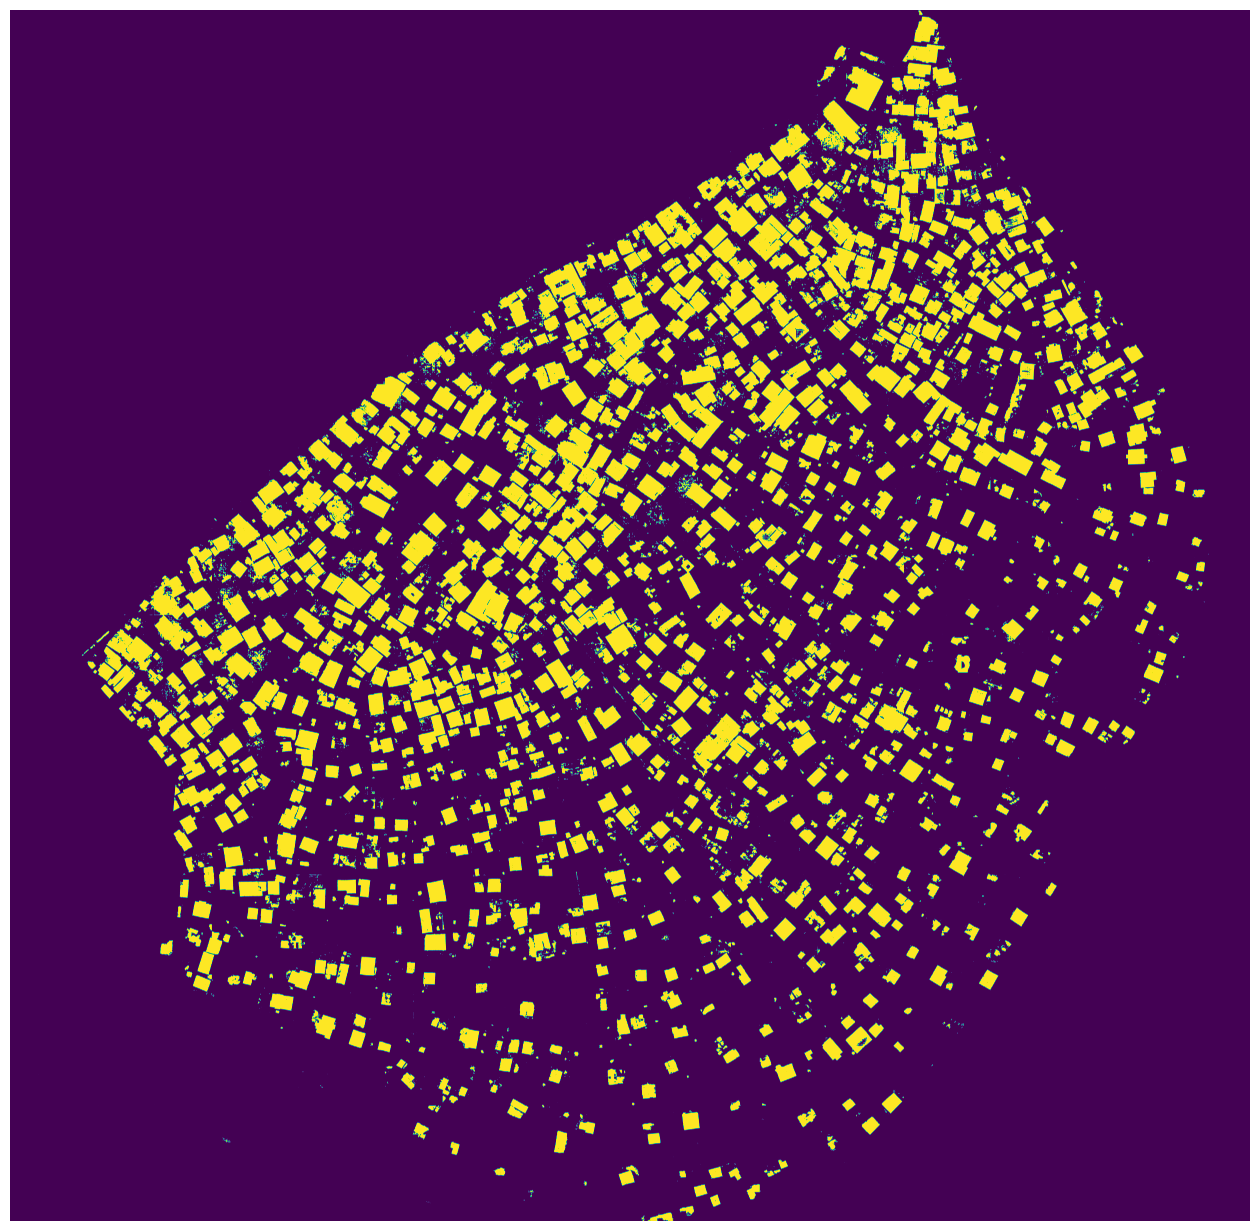

In [ ]:
plt.figure(figsize=[16,16])
plt.imshow(pred_img_orto)
plt.axis('off')

Vamos então converter a imagem binária para arquivo vetorial transformando cada área definida como área construída em um poligono:

In [ ]:
from rasterio.features import shapes
from shapely.geometry import shape

In [ ]:
shape_gen = ((shape(s), v) for s, v in shapes(pred_img_orto, mask=pred_img_orto, transform=predic_orto.transform))

In [ ]:
Poly_gdf = gpd.GeoDataFrame(dict(zip(["geometry", "class"], zip(*shape_gen))), crs=predic_orto.crs)

In [ ]:
Poly_gdf

geometry  class
0      POLYGON ((302697.176 700533.202, 302697.386 70...    1.0
1      POLYGON ((302706.290 700526.692, 302706.290 70...    1.0
2      POLYGON ((302711.876 700520.938, 302711.876 70...    1.0
3      POLYGON ((302709.776 700518.796, 302709.776 70...    1.0
4      POLYGON ((302709.482 700517.284, 302709.482 70...    1.0
...                                                  ...    ...
13569  POLYGON ((302490.704 699631.546, 302490.830 69...    1.0
13570  POLYGON ((302501.876 699631.378, 302501.876 69...    1.0
13571  POLYGON ((302491.922 699634.990, 302492.006 69...    1.0
13572  POLYGON ((302511.158 699637.258, 302511.200 69...    1.0
13573  POLYGON ((302513.678 699630.958, 302513.678 69...    1.0

[13574 rows x 2 columns]

Podemos filtrar alguns poligono com área menor que 1 metro quadrado para remover ruídos.

In [ ]:
Poly_gdf_filtred = Poly_gdf[Poly_gdf.area > 1].copy()

Por fim, plotamos o resultado e salvamos em um json:

<Axes: >

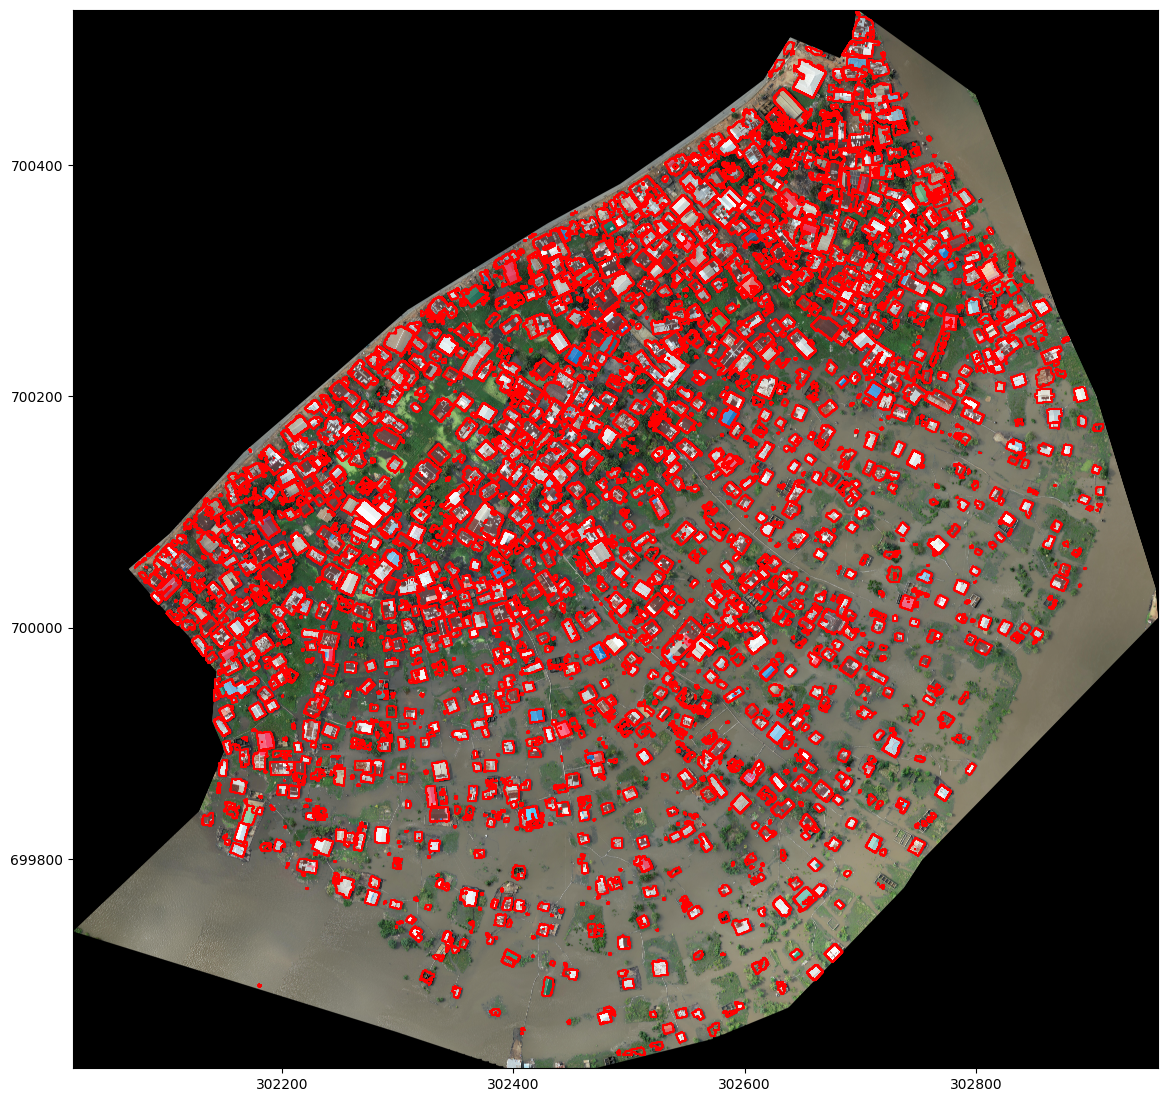

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))
with rasterio.open(path_img_to_pred) as src:
    gdf = Poly_gdf_filtred.to_crs(src.crs.to_dict()['init'])
    show(src,ax=ax)
gdf.boundary.plot(ax=ax, edgecolor='red')

In [ ]:
Poly_gdf_filtred.to_file('Constructions.json')

## Attention U-Net

Para melhorar o desempenho da segmentação, Khened et al. e Roth et ai. contou com modelos anteriores de localização de objetos adicionais para separar a localização e as etapas de segmentação subsequentes. Isso pode ser alcançado integrando gates de atenção no topo da arquitetura U-Net, sem treinar modelos adicionais.
Como resultado, os gates de atenção incorporados ao U-Net podem melhorar a sensibilidade e a precisão do modelo para os pixels do primeiro plano sem exigir sobrecarga de computação significativa. Os gates de atenção podem suprimir progressivamente as respostas dos recursos em regiões de fundo irrelevantes.

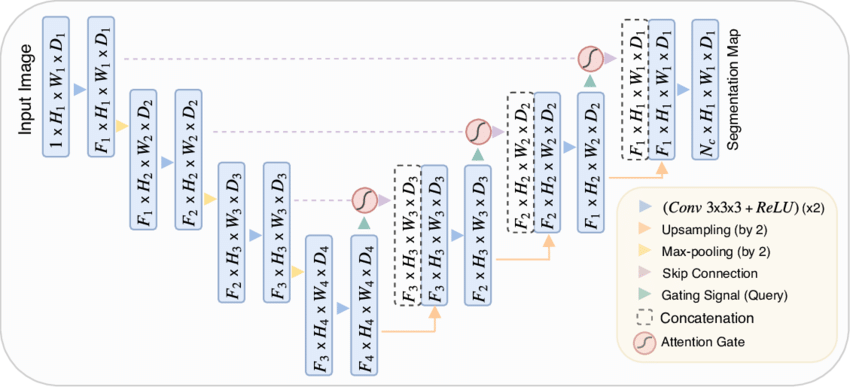

Os gates de atenção são implementados antes da operação de concatenação para mesclar apenas as ativações relevantes. Gradientes originários de regiões de fundo são ponderados para baixo durante a passagem para trás. Isso permite que os parâmetros do modelo em camadas anteriores sejam atualizados com base nas regiões espaciais relevantes para uma determinada tarefa.

Para melhorar ainda mais o mecanismo de atenção, Oktay et al. propôs um mecanismo de grade de atenção. Ao implementar gating baseado em grade, o sinal de gating não é um único vetor global para todos os pixels da imagem, mas um sinal de grade condicionado à informação espacial da imagem. O sinal de gating para cada conexão de salto agrega recursos de imagem de várias escalas de imagem.
Ao usar o gating baseado em grade, isso permite que os coeficientes de atenção sejam mais específicos para as regiões locais, pois aumenta a resolução da grade do sinal de consulta. Isso alcança melhor desempenho em comparação com gating baseado em um vetor de recurso global.

### Módulo de Atenção:

“Need to pay attention” de Jetley et al. introduziu o módulo de atenção treinável de ponta a ponta. As portas de atenção são comumente usadas na análise de imagens naturais e no processamento de linguagem natural.

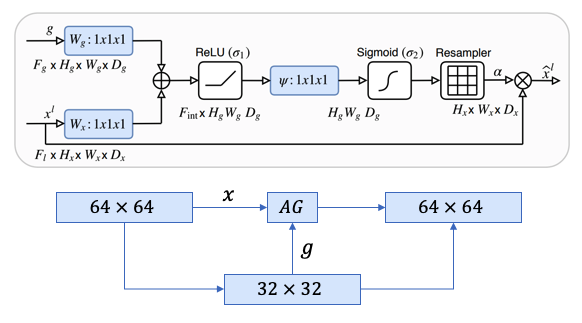

A atenção é usada para realizar agrupamentos específicos de classe, o que resulta em um desempenho de classificação de imagem mais preciso e robusto. Esses mapas de atenção podem ampliar as regiões relevantes, demonstrando assim uma generalização superior em vários conjuntos de dados de referência.

O modo como a função de atenção funciona é pelo uso de uma região de imagem por proposta de região iterativa e corte. Mas isso geralmente não é diferenciável e depende do aprendizado por reforço (uma técnica baseada em amostragem chamada REINFORCE) para atualizações de parâmetros que resultam na otimização desses modelos mais difíceis.
Por outro lado, a atenção suave é probabilística e utiliza retropropagação padrão sem necessidade de amostragem Monte Carlo. O método de atenção suave de Seo et al. demonstra melhorias implementando mapas de atenção não uniformes e não rígidos que são mais adequados para formas de objetos naturais vistos em imagens reais.

Vamos implementar a Attention U-Net:

In [ ]:
from keras.layers import LeakyReLU
from keras.layers import multiply
from keras import backend as K

def expend_as(tensor, rep):
		my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)
		return my_repeat


def UnetGatingSignal(input, is_batchnorm=False):
		shape = K.int_shape(input)
		x = Conv2D(shape[3] * 2, (1, 1), strides=(1, 1), padding="same")(input)
		if is_batchnorm:
			x = BatchNormalization()(x)
		x = Activation('relu')(x)
		return x

def AttnGatingBlock(x, g, inter_shape):
		shape_x = K.int_shape(x)  # 32
		shape_g = K.int_shape(g)  # 16

		theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
		shape_theta_x = K.int_shape(theta_x)

		phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
		upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same')(phi_g)  # 16

		concat_xg = add([upsample_g, theta_x])
		act_xg = Activation('relu')(concat_xg)
		psi = Conv2D(1, (1, 1), padding='same')(act_xg)
		sigmoid_xg = Activation('sigmoid')(psi)
		shape_sigmoid = K.int_shape(sigmoid_xg)
		upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

		upsample_psi = expend_as(upsample_psi, shape_x[3])

		y = multiply([upsample_psi, x])

		result = Conv2D(shape_x[3], (1, 1), padding='same')(y)
		result_bn = BatchNormalization()(result)
		return result_bn

In [ ]:
inputs = Input(shape=x_train.shape[1:])
conv = Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same')(inputs)
conv = LeakyReLU(alpha=0.3)(conv)

conv1 = Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same')(conv)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
conv1 = Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
conv3 = Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), kernel_initializer='he_uniform', padding='same')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)
conv4 = Conv2D(256, (3, 3), kernel_initializer='he_uniform', padding='same')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), kernel_initializer='he_uniform', padding='same')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)
conv5 = Conv2D(512, (3, 3), kernel_initializer='he_uniform', padding='same')(conv5)
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

conv6 = Conv2D(1024, (3, 3), kernel_initializer='he_uniform', padding='same')(pool5)
conv6 = BatchNormalization()(conv6)
conv6 = Activation('relu')(conv6)
conv6 = Conv2D(512, (3, 3), kernel_initializer='he_uniform', padding='same')(conv6)
conv6 = BatchNormalization()(conv6)
conv6 = Activation('relu')(conv6)


gating1 = UnetGatingSignal(conv6, is_batchnorm=True)
attn_1 = AttnGatingBlock(conv5, gating1, 512)
up1 = concatenate([Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same',activation="relu")(conv6), attn_1], axis=3)
conv7 = Conv2D(512, (3, 3), kernel_initializer='he_uniform', padding='same')(up1)
conv7 = BatchNormalization()(conv7)
conv7 = Activation('relu')(conv7)
conv7 = Conv2D(256, (3, 3), kernel_initializer='he_uniform', padding='same')(conv7)
conv7 = BatchNormalization()(conv7)
conv7 = Activation('relu')(conv7)

gating2 = UnetGatingSignal(conv7, is_batchnorm=True)
attn_2 = AttnGatingBlock(conv4, gating2, 256)
up2 = concatenate([Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same',activation="relu")(up1), attn_2], axis=3)
conv8 = Conv2D(256, (3, 3), kernel_initializer='he_uniform', padding='same')(up2)
conv8 = BatchNormalization()(conv8)
conv8 = Activation('relu')(conv8)
conv8 = Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same')(conv8)
conv8 = BatchNormalization()(conv8)
conv8 = Activation('relu')(conv8)


gating3 = UnetGatingSignal(conv8, is_batchnorm=True)
attn_3 = AttnGatingBlock(conv3, gating3, 128)
up3 = concatenate([Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same',activation="relu")(up2), attn_3], axis=3)
conv9 = Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same')(up3)
conv9 = BatchNormalization()(conv9)
conv9 = Activation('relu')(conv9)
conv9 = Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same')(conv9)
conv9 = BatchNormalization()(conv9)
conv9 = Activation('relu')(conv9)


gating4 = UnetGatingSignal(conv9, is_batchnorm=True)
attn_4 = AttnGatingBlock(conv2, gating4, 64)
up4 = concatenate([Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same',activation="relu")(up3), attn_4], axis=3)
conv10 = Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same')(up4)
conv10 = BatchNormalization()(conv10)
conv10 = Activation('relu')(conv10)
conv10 = Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same')(conv10)
conv10 = BatchNormalization()(conv10)
conv10 = Activation('relu')(conv10)

gating5 = UnetGatingSignal(conv10, is_batchnorm=True)
attn_5 = AttnGatingBlock(conv1, gating5, 32)
up5 = concatenate([Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same',activation="relu")(up4), attn_5], axis=3)
conv11 = Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same')(up5)
conv11 = BatchNormalization()(conv11)
conv11 = Activation('relu')(conv11)
conv11 = Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same')(conv11)
conv11 = BatchNormalization()(conv11)
conv11 = Activation('relu')(conv11)

conv12 = Conv2D(1, (1, 1), activation='sigmoid')(conv11)

model = Model(inputs=inputs, outputs=conv12)
model.compile(optimizer=Adam(lr = 1e-5,decay=1e-6), loss = jaccard_loss, metrics=[jaccard_coef, 'accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_68 (Conv2D)             (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256, 256, 32  0           ['conv2d_68[0][0]']              
                                )                                                           

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 batch_normalization_75 (BatchN  (None, 16, 16, 512)  2048       ['conv2d_86[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_66 (Activation)     (None, 16, 16, 512)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 conv2d_87 (Conv2D)             (None, 16, 16, 256)  1179904     ['activation_66[0][0]']          
                                                                                                  
 batch_normalization_76 (BatchN  (None, 16, 16, 256)  1024       ['conv2d_87[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

In [ ]:
history = model.fit_generator(train_generator,steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
                              epochs=300, validation_data=(x_test,y_test))

<ipython-input-97-3caab27a3ebc>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,


Epoch 1/300
104/104 [==============================] - 31s 206ms/step - loss: 0.6939 - jaccard_coef: 0.3060 - accuracy: 0.5419 - val_loss: 0.7874 - val_jaccard_coef: 0.2126 - val_accuracy: 0.2997
Epoch 2/300
104/104 [==============================] - 18s 169ms/step - loss: 0.6275 - jaccard_coef: 0.3728 - accuracy: 0.7115 - val_loss: 0.7468 - val_jaccard_coef: 0.2532 - val_accuracy: 0.7158
Epoch 3/300
104/104 [==============================] - 17s 167ms/step - loss: 0.5639 - jaccard_coef: 0.4360 - accuracy: 0.7975 - val_loss: 0.6669 - val_jaccard_coef: 0.3331 - val_accuracy: 0.8746
Epoch 4/300
104/104 [==============================] - 17s 166ms/step - loss: 0.5235 - jaccard_coef: 0.4769 - accuracy: 0.8472 - val_loss: 0.5751 - val_jaccard_coef: 0.4249 - val_accuracy: 0.9055
Epoch 5/300
104/104 [==============================] - 17s 167ms/step - loss: 0.4873 - jaccard_coef: 0.5128 - accuracy: 0.8716 - val_loss: 0.5262 - val_jaccard_coef: 0.4738 - val_accuracy: 0.8951
Epoch 6/300
104/104 

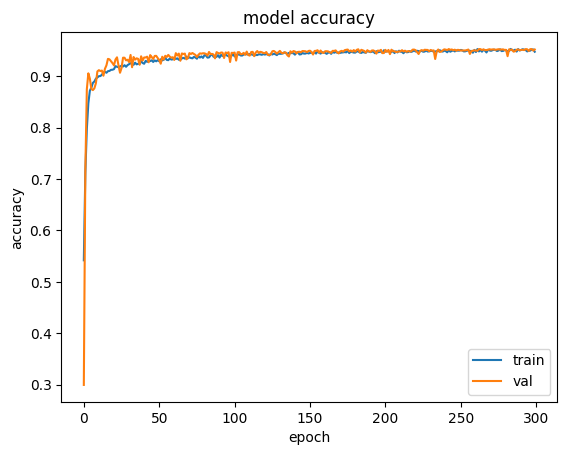

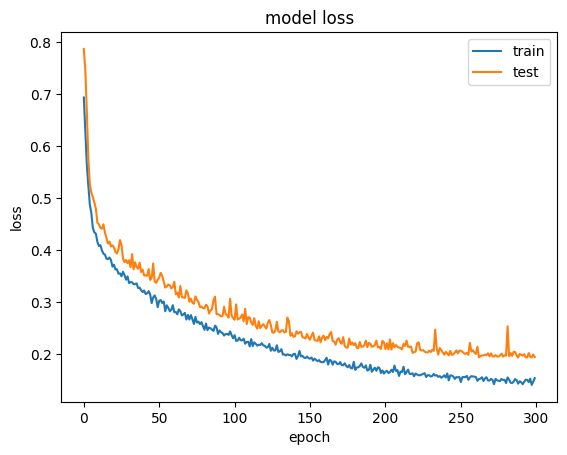

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Assim, podemos calcular a acurácia para o conjunto de teste:

In [ ]:
predict = model.predict(x_test)

12/12 [==============================] - 5s 90ms/step


In [ ]:
pred = np.round(predict)

In [ ]:
accuracy = accuracy_score(y_test.flatten(),pred.flatten())
print(accuracy)

0.9517484452989367


In [ ]:
y_test.shape

(360, 256, 256)

Por fim, vamos plotar um exemplo do resultado previsto em comparação com a máscara original:

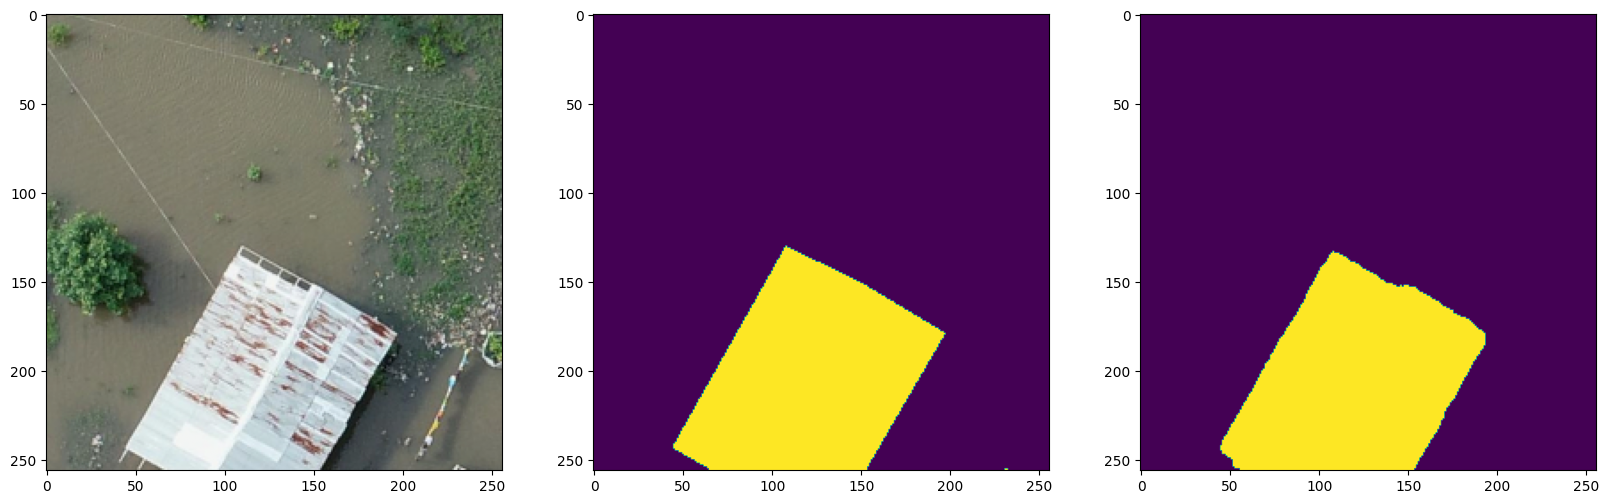

In [ ]:
i = 0
plt.figure(figsize=(20,8))
plt.subplot(1,3,1),
plt.imshow(x_test[i])
plt.subplot(1,3,2),
plt.imshow(y_test[i,:,:])
plt.subplot(1,3,3),
plt.imshow(pred[i,:,:,0])